<a href="https://colab.research.google.com/github/Swethan-colab/Sonu27/blob/main/GRU_Gridsearchcv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

path = "/content/drive/MyDrive/NLH.xlsx"
# Read the Excel file
df = pd.read_excel(path)

# Display the DataFrame
print(df)



     Unnamed: 0 Unnamed: 1  Unnamed: 2
0           NaN       epsn    sigmaiso
1           NaN    0.00005    2.592593
2           NaN    0.00055   28.518519
3           NaN    0.00105   54.444444
4           NaN    0.00155   62.387902
..          ...        ...         ...
356         NaN    0.01755  168.331045
357         NaN    0.01805  168.789461
358         NaN    0.01855  169.247876
359         NaN    0.01905  169.706291
360         NaN    0.01955  170.164706

[361 rows x 3 columns]


In [ ]:
column_names = ['index', 'epsn', 'sigmaiso']  # Replace with your desired names
df.columns = column_names


# Assuming the column with NaN values is named 'Unnamed: 0'
df_ = df[['epsn', 'sigmaiso']]
df__ = df_.iloc[1:]
print(df__)

        epsn    sigmaiso
1    0.00005    2.592593
2    0.00055   28.518519
3    0.00105   54.444444
4    0.00155   62.387902
5    0.00205   64.874616
..       ...         ...
356  0.01755  168.331045
357  0.01805  168.789461
358  0.01855  169.247876
359  0.01905  169.706291
360  0.01955  170.164706

[360 rows x 2 columns]


In [ ]:

import torch

# Assuming 'df__' is your DataFrame
# Check for missing values
if df__['sigmaiso'].isnull().any():
    print("Warning: 'sigmaiso' column contains missing values (NaNs).")
    # Choose a solution: remove rows, impute missing values, etc.
    df__ = df__.dropna(subset=['sigmaiso'])  # Example: Remove rows with NaNs in 'sigmaiso'

# Check data types and convert to numeric if needed
if not pd.api.types.is_numeric_dtype(df__['sigmaiso']):
    print("Warning: 'sigmaiso' column may contain non-numerical data types.")
    # Use .loc to safely modify the column
    df__.loc[:, 'sigmaiso'] = pd.to_numeric(df__['sigmaiso'], errors='coerce')

# Assuming data is now clean

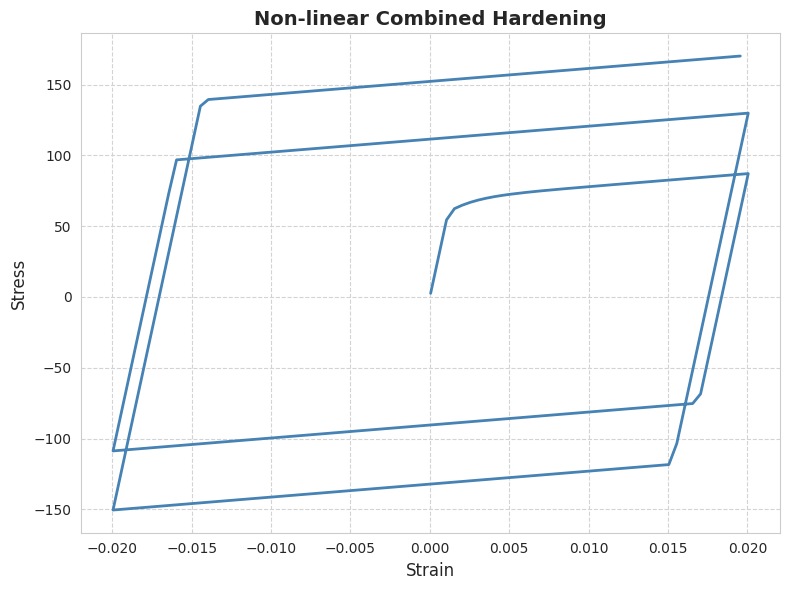

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Datacorrection in espn values

if df__['epsn'].isnull().any():
    print("Warning: 'sigmaiso' column contains missing values (NaNs).")
    # Choose a solution: remove rows, impute missing values, etc.
    df__ = df__.dropna(subset=['epsn'])  # Example: Remove rows with NaNs in 'sigmaiso'

# Check data types and convert to numeric if needed
if not pd.api.types.is_numeric_dtype(df__['epsn']):
    print("Warning: 'epsn' column may contain non-numerical data types.")
    # Use .loc to safely modify the column
    df__.loc[:, 'epsn'] = pd.to_numeric(df__['epsn'], errors='coerce')

# Assuming data is now clean
epsn = (df__['epsn'].values.astype(np.float32))
sigmaiso = (df__['sigmaiso'].values.astype(np.float32))

sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.plot(epsn, sigmaiso, color='steelblue', linewidth=2)  # Customize line color and width

plt.xlabel('Strain', fontsize=12)
plt.ylabel('Stress', fontsize=12)
plt.title('Non-linear Combined Hardening', fontsize=14, fontweight='bold')

# Customize gridlines
plt.grid(color='lightgray', linestyle='--')

plt.tight_layout()  # Adjust spacing

plt.show()


In [ ]:

def normalize(data):
  """
  Normalizes data to a range of [0, 1].

  Args:
      data (torch.Tensor): The data to be normalized.

  Returns:
      torch.Tensor: The normalized data.
  """
  min_val = torch.min(data)
  max_val = torch.max(data)
  return (data - min_val) / (max_val - min_val)
def z_score(data):
  return (data - data.mean()) / data.std()

In [ ]:
import torch.nn as nn

class MyModel(nn.Module):
  def __init__(self,hidden_size,num_layers):
    super(MyModel, self).__init__()
    self.gru = nn.GRU(input_size=1, hidden_size=hidden_size,num_layers=num_layers)

    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = self.gru(x)[0]  # Access hidden state from GRU1
     # Access hidden state from GRU2
    x = self.linear(x)
    return x







In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

class PyTorchClassifier(BaseEstimator, ClassifierMixin, nn.Module):
    def __init__(self, hidden_size=64, num_layers=2, learning_rate=0.01, optimizer=torch.optim.Adam, criterion=nn.MSELoss()):
        super(PyTorchClassifier, self).__init__()  # Call superclass __init__ first
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.criterion = criterion



    def fit(self,epsn,sigmaiso):
        x = torch.from_numpy(epsn.astype(np.float32)).unsqueeze(1)
        y = torch.from_numpy(sigmaiso.astype(np.float32)).unsqueeze(1)



        x_train = normalize(x)

        y_train = normalize(y)

        train_dataset = TensorDataset((x_train), (y_train))
        batch_size = 1000
        # Create data loaders for each set

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        # Create model
        model = MyModel(self.hidden_size,self.num_layers)

        # Create optimizer
        optimizer = self.optimizer(model.parameters(), lr=self.learning_rate)

        # Training loop

        for data,target in train_dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = self.criterion(outputs, target)  # Assuming y_train is not batched
            loss.backward()
            optimizer.step()

        self.model = model
        self.classes_ = np.unique(y)
        return self

    def predict(self, epsn):
        with torch.no_grad():
            x = torch.from_numpy(epsn.astype(np.float32)).unsqueeze(1)
            predictions = self.model(x)
        return predictions.numpy()

In [ ]:
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [2, 3, 4],
    'learning_rate': [0.01, 0.001,0.0008],
    'optimizer': [torch.optim.Adam, torch.optim.SGD,torch.optim.AdamW,torch.optim.RMSprop,torch.optim.Adagrad,torch.optim.Adamax],
    'criterion': [nn.MSELoss(), nn.HuberLoss(delta=1.0), nn.L1Loss()]
}

model1 = PyTorchClassifier()
grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(epsn,sigmaiso)


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


print(best_params)

{'criterion': L1Loss(), 'hidden_size': 64, 'learning_rate': 0.01, 'num_layers': 3, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
